In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy.sparse import csr_matrix
from scipy.spatial import distance
import os
import warnings; warnings.simplefilter('ignore')
import anndata
import scrublet as scr

import seaborn as sns
sns.set_style('white')

np.random.seed(0)
sc.settings.verbosity = 3 

In [2]:
sc.logging.print_versions()

scanpy==1.4.5 anndata==0.7.5 umap==0.3.10 numpy==1.17.2 scipy==1.5.2 pandas==1.1.2 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [3]:
sc.set_figure_params(scanpy=True, dpi=80)

### S5C

In [14]:
adata_cd4 = sc.read('veatch_cd4_all20.h5ad')
adata_cd8 = sc.read('veatch_cd8_all20.h5ad')

In [15]:
adata_cd4.obs['type'] = 'CD4'
adata_cd8.obs['type'] = 'CD8'

In [16]:
adata_cd4.obs['labels'] = adata_cd4.obs['labels'].astype('object')
adata_cd8.obs['labels'] = adata_cd8.obs['labels'].astype('object')

In [17]:
adata_cd4.obs['violin_label'] = adata_cd4.obs['type'] + ' ' + adata_cd4.obs['labels']
adata_cd8.obs['violin_label'] = adata_cd8.obs['type'] + ' ' + adata_cd8.obs['labels']

In [18]:
adata_cd8.obs['violin_label'][(adata_cd8.obs['labels'] == 'CXCL13+ TYMS+') | (adata_cd8.obs['labels'] == 'CXCL13+ TCF7+')| (adata_cd8.obs['labels'] == 'CXCL13+ TYMS-')] = 'CD8 CXCL13+'

In [19]:
adata = adata_cd4.concatenate([adata_cd8])

In [20]:
sns.set_style('white')

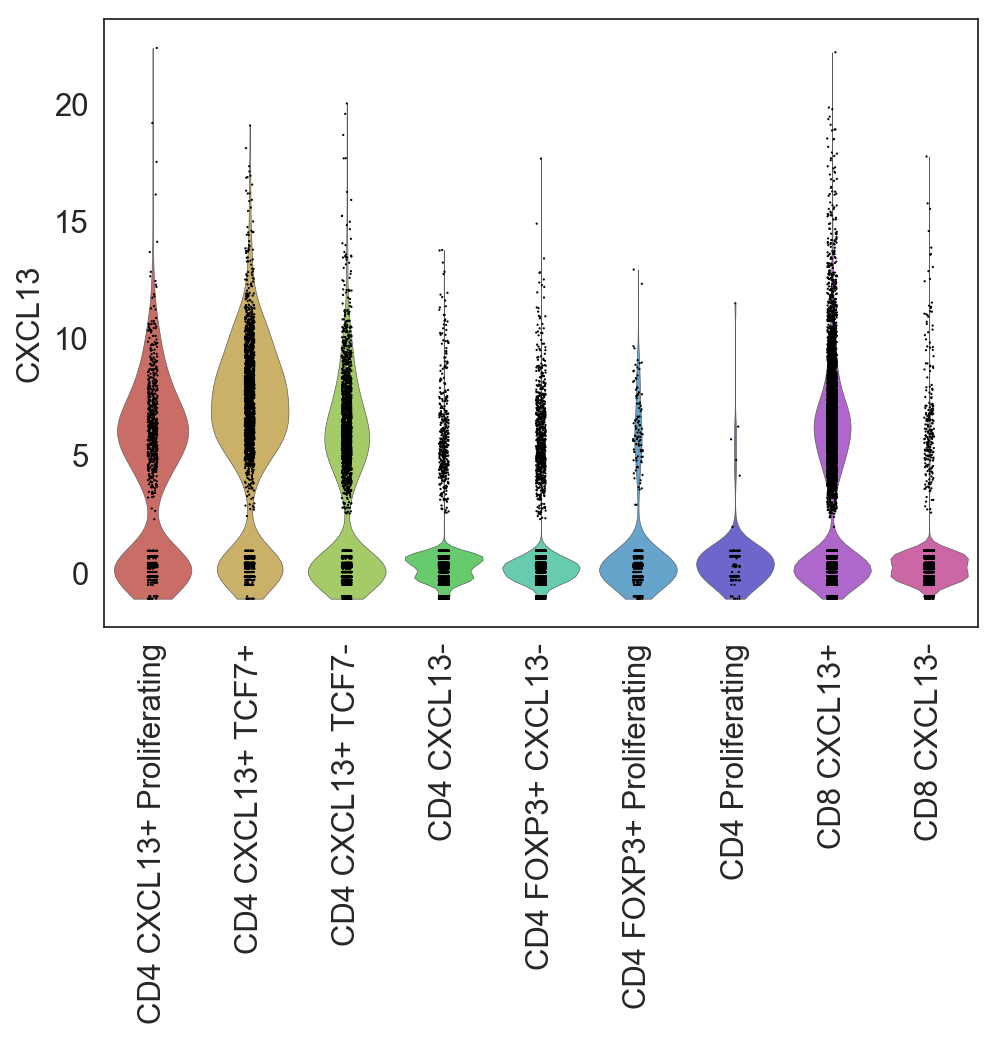

In [22]:
fig, ax = plt.subplots(figsize=(7,5))
sc.pl.violin(adata, keys='CXCL13',groupby='violin_label', rotation=90,jitter=0.05,
             palette=sns.color_palette("hls", 9),linewidth=0.3,ax=ax)

### S5D

In [25]:
adata_m = sc.read('veatch_myeloid_all20.h5ad')

In [27]:
adata_m.obs['violin_label'] = adata_m.obs['label'].astype('object')
adata_m.obs['violin_label'][(adata_m.obs['label'] == 'Macrophages I') | (adata_m.obs['label'] == 'Macrophages II')| (adata_m.obs['label'] == 'Macrophages III')] = 'macrophages'

In [29]:
adata = adata_cd4.concatenate([adata_cd8,adata_m])

In [30]:
adata.obs['violin_label'] = adata.obs['violin_label'].astype('object')
adata.obs['violin_label'][(adata.obs['violin_label'] == 'CD8 CXCL13+ TYMS+')] = 'CD8 CXCL13+ Proliferating'
adata.obs['violin_label'][(adata.obs['violin_label'] == 'CD4 CXCL13+ Proliferating') | (adata.obs['violin_label'] == 'CD4 FOXP3+ Proliferating')] = 'CD4 Proliferating'

... storing 'BCR_Heavy_V_gene_Dominant' as categorical
... storing 'BCR_Heavy_D_gene_Dominant' as categorical
... storing 'BCR_Heavy_J_gene_Dominant' as categorical
... storing 'BCR_Heavy_C_gene_Dominant' as categorical
... storing 'BCR_Heavy_CDR3_Nucleotide_Dominant' as categorical
... storing 'BCR_Heavy_CDR3_Translation_Dominant' as categorical
... storing 'BCR_Light_V_gene_Dominant' as categorical
... storing 'BCR_Light_J_gene_Dominant' as categorical
... storing 'BCR_Light_C_gene_Dominant' as categorical
... storing 'BCR_Light_CDR3_Nucleotide_Dominant' as categorical
... storing 'BCR_Light_CDR3_Translation_Dominant' as categorical
... storing 'TCR_Alpha_Gamma_V_gene_Dominant' as categorical
... storing 'TCR_Alpha_Gamma_J_gene_Dominant' as categorical
... storing 'TCR_Alpha_Gamma_C_gene_Dominant' as categorical
... storing 'TCR_Alpha_Gamma_CDR3_Nucleotide_Dominant' as categorical
... storing 'TCR_Alpha_Gamma_CDR3_Translation_Dominant' as categorical
... storing 'TCR_Beta_Delta_V_gen

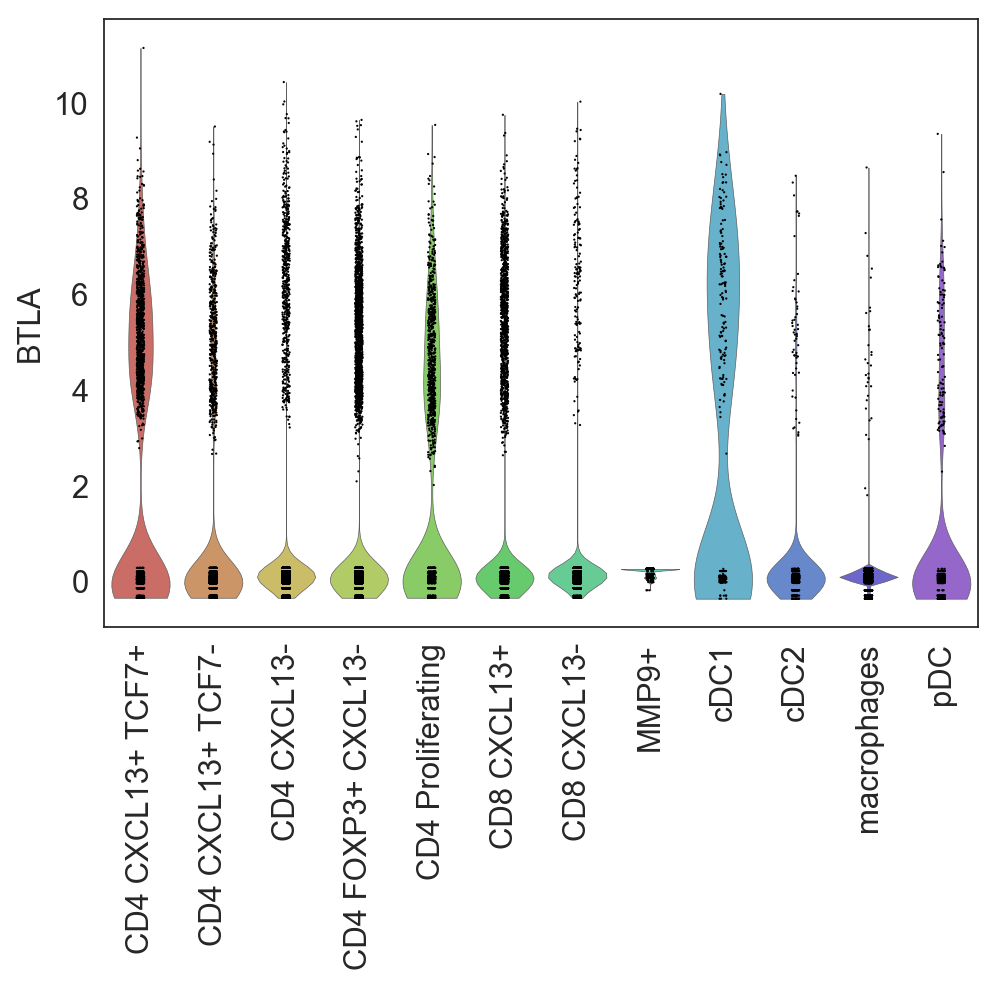

In [31]:
fig, ax = plt.subplots(figsize=(7,5))
sc.pl.violin(adata, keys='BTLA',groupby='violin_label', rotation=90,jitter=0.05,
             palette=sns.color_palette("hls", 15),linewidth=0.3,ax=ax)

### S5E

In [35]:
adata = adata[adata.obs['batch'] != '2']

In [36]:
adata.obs['IL-21'] = adata[:,'IL21'].X

Trying to set attribute `.obs` of view, copying.


In [37]:
adata.obs['type']

606190-0-0    CD4
512232-0-0    CD4
41037-0-0     CD4
684137-0-0    CD4
582003-0-0    CD4
             ... 
883521-4-1    CD8
470918-4-1    CD8
434777-4-1    CD8
327151-4-1    CD8
816659-4-1    CD8
Name: type, Length: 42105, dtype: category
Categories (2, object): ['CD4', 'CD8']

In [39]:
adata.obs['new_labels'] = adata.obs['violin_label'].astype('object')
adata.obs['new_labels'][adata.obs['type'] == 'CD8'] = 'CD8 T'

In [40]:
df = (adata.obs['new_labels'][adata.obs['IL-21'] > 1].value_counts()/adata.obs['new_labels'].value_counts())*100

Text(0, 0.5, 'percent expressing IL-21')

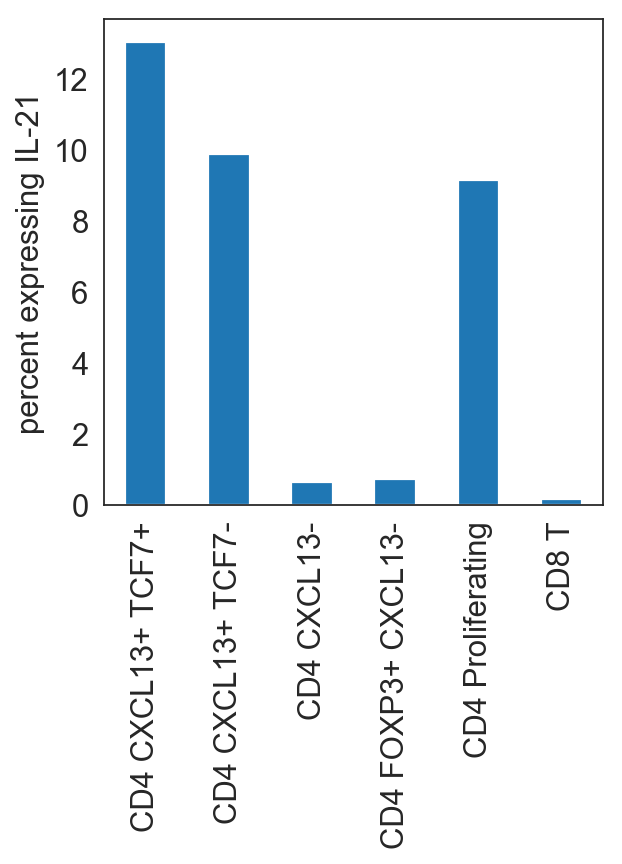

In [41]:
ax = df.plot.bar()
ax.set_ylabel('percent expressing IL-21')

### S5F

In [42]:
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test

In [44]:
# TCGA data imported using TCGAbiolinks
mtx = pd.read_csv('data/TCGA-SKCM_matrix.csv',index_col=0).T
meta = pd.read_csv('data/TCGA-SKCM_meta.csv',index_col=0)
barcode = []
for x in mtx.index:
    barcode.append(x.split('-')[0] + '-' + x.split('-')[1] + '-' + x.split('-')[2])

mtx.index = barcode
col = []
for x in mtx.columns:
    col.append(x.split('|')[0])

mtx.columns = col
meta.index = meta['bcr_patient_barcode']
meta = meta.drop(columns='bcr_patient_barcode')

df = mtx.join(meta, how='inner')
df1 = df[['CXCL13','CD4','BTLA','IL21','vital_status','days_to_death']]
df1['CXCL13/CD4'] = df1['CXCL13']/df1['CD4']
df1['BTLA/CD4'] = df1['BTLA']/df1['CD4']

df1['alive'] = 0
df1['alive'][df['vital_status'] == 'Dead'] = 1
df1['survival'] = 99999
df1['survival'][df['vital_status'] == 'Dead'] = df['days_to_death'][df['vital_status'] == 'Dead']
df1['survival'][df1['survival'].isna()] = 10000
df1 = df1[df1['survival'] != 10000]
df1['survival'] = df1['survival']/30

df1 = df1[~df1['CXCL13'].isna()]
df1 = df1[~df1['BTLA'].isna()]
df1 = df1[~df1['IL21'].isna()]
df1 = df1[~df1['CD4'].isna()]

df1['CXCL13>med'] = df1['CXCL13'] > np.median(df1['CXCL13'])
df1['CXCL13/CD4>med'] = df1['CXCL13/CD4'] > np.median(df1['CXCL13/CD4'])
df1['BTLA>med'] = df1['BTLA'] > np.median(df1['BTLA'])
df1['BTLA/CD4>med'] = df1['BTLA/CD4'] > np.median(df1['BTLA/CD4'])
df1['IL21>0'] = df1['IL21'] > 0

cph = CoxPHFitter()

(0, 363)

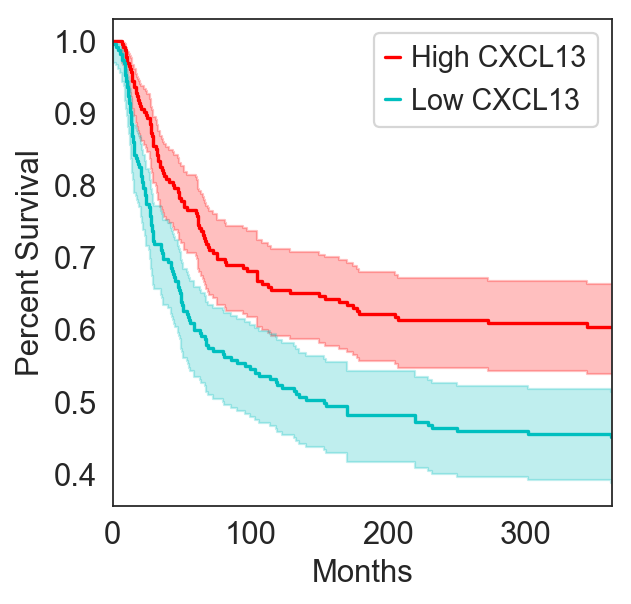

In [45]:
df2 = df1[['CXCL13>med','alive','survival']]
cph.fit(df2, 'survival', event_col='alive')

results=logrank_test(df1['survival'][df1['CXCL13'] > np.median(df1['CXCL13'])],df1['survival'][df1['CXCL13'] < np.median(df1['CXCL13'])],event_observed_A=df1['alive'][df1['CXCL13'] > np.median(df1['CXCL13'])], event_observed_B=df1['alive'][df1['CXCL13'] < np.median(df1['CXCL13'])])

kmf = KaplanMeierFitter() 

kmf.fit(df1['survival'][df1['CXCL13'] > np.median(df1['CXCL13'])], df1['alive'][df1['CXCL13'] > np.median(df1['CXCL13'])],label='High CXCL13')

ax = kmf.plot(ci_show=True,color='red')

kmf.fit(df1['survival'][df1['CXCL13'] < np.median(df1['CXCL13'])], df1['alive'][df1['CXCL13'] < np.median(df1['CXCL13'])],label='Low CXCL13')

kmf.plot(ci_show=True,ax=ax,color='c')

ax.set_ylabel('Percent Survival')
ax.set_xlabel('Months')
ax.set_xlim(0,363)

### S5G

(0, 363)

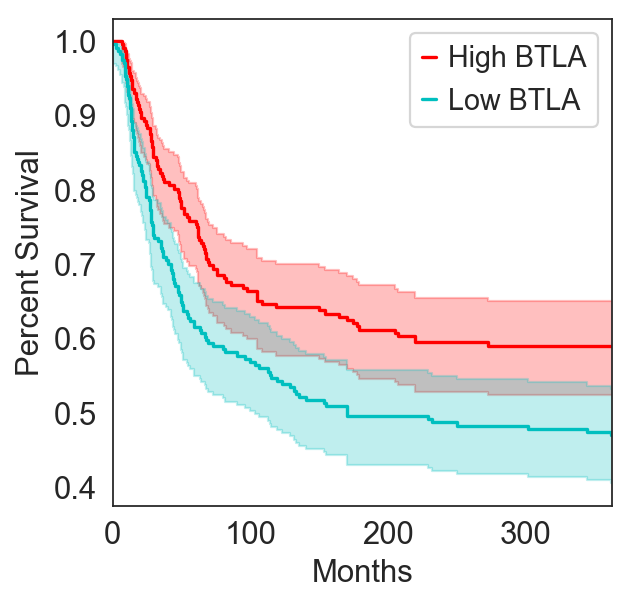

In [46]:
df2 = df1[['BTLA>med','alive','survival']]
cph.fit(df2, 'survival', event_col='alive')

results=logrank_test(df1['survival'][df1['BTLA'] > np.median(df1['BTLA'])],df1['survival'][df1['BTLA'] < np.median(df1['BTLA'])],event_observed_A=df1['alive'][df1['BTLA'] > np.median(df1['BTLA'])], event_observed_B=df1['alive'][df1['BTLA'] < np.median(df1['BTLA'])])

kmf = KaplanMeierFitter() 

kmf.fit(df1['survival'][df1['BTLA'] > np.median(df1['BTLA'])], df1['alive'][df1['BTLA'] > np.median(df1['BTLA'])],label='High BTLA')

ax = kmf.plot(ci_show=True,color='red')

kmf.fit(df1['survival'][df1['BTLA'] < np.median(df1['BTLA'])], df1['alive'][df1['BTLA'] < np.median(df1['BTLA'])],label='Low BTLA')

kmf.plot(ci_show=True,ax=ax,color='c')

ax.set_ylabel('Percent Survival')
ax.set_xlabel('Months')
ax.set_xlim(0,363)

### S5H

(0, 363)

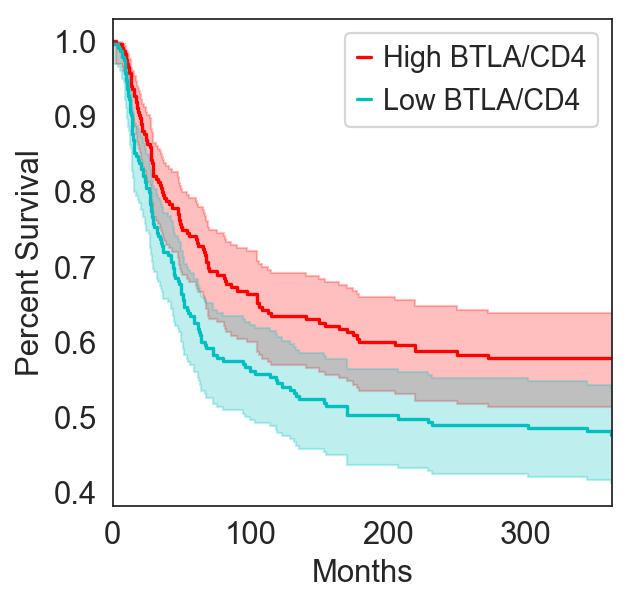

In [47]:
df2 = df1[['BTLA/CD4>med','alive','survival']]
cph.fit(df2, 'survival', event_col='alive')

results=logrank_test(df1['survival'][df1['BTLA/CD4'] > np.median(df1['BTLA/CD4'])],df1['survival'][df1['BTLA/CD4'] < np.median(df1['BTLA/CD4'])],event_observed_A=df1['alive'][df1['BTLA/CD4'] > np.median(df1['BTLA/CD4'])], event_observed_B=df1['alive'][df1['BTLA/CD4'] < np.median(df1['BTLA/CD4'])])

kmf = KaplanMeierFitter() 

kmf.fit(df1['survival'][df1['BTLA/CD4'] > np.median(df1['BTLA/CD4'])], df1['alive'][df1['BTLA/CD4'] > np.median(df1['BTLA/CD4'])],label='High BTLA/CD4')

ax = kmf.plot(ci_show=True,color='red')

kmf.fit(df1['survival'][df1['BTLA/CD4'] < np.median(df1['BTLA/CD4'])], df1['alive'][df1['BTLA/CD4'] < np.median(df1['BTLA/CD4'])],label='Low BTLA/CD4')

kmf.plot(ci_show=True,ax=ax,color='c')

ax.set_ylabel('Percent Survival')
ax.set_xlabel('Months')
ax.set_xlim(0,363)

### S5I

(0, 363)

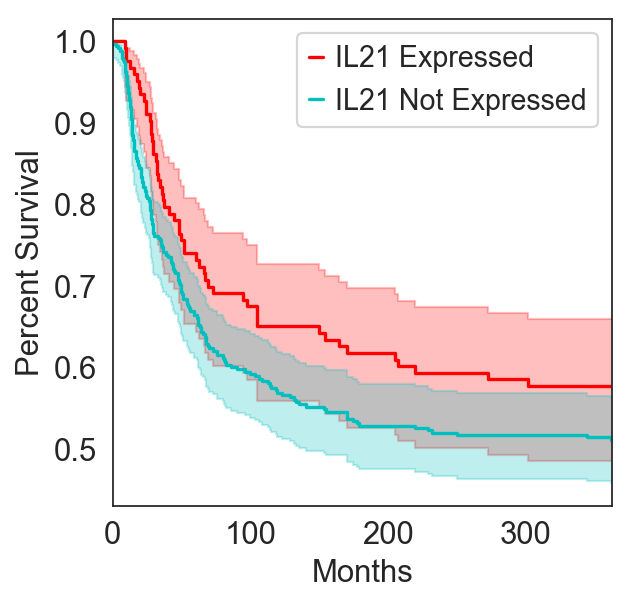

In [48]:
kmf = KaplanMeierFitter() 

kmf.fit(df1['survival'][df1['IL21'] > 0], df1['alive'][df1['IL21'] > 0],label='IL21 Expressed')

ax = kmf.plot(ci_show=True,color='red')

kmf.fit(df1['survival'][df1['IL21'] == 0], df1['alive'][df1['IL21'] == 0],label='IL21 Not Expressed')

kmf.plot(ci_show=True,ax=ax,color='c')

ax.set_ylabel('Percent Survival')
ax.set_xlabel('Months')
ax.set_xlim(0,363)